In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [ ]:
from tqdm.notebook import tqdm, trange

In [4]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [5]:
save_dir = "result_covidcast_adj_2_iv_5"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. data

In [6]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [7]:
GPi = np.load('data/GPi.npz')

In [8]:
data

,geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
0,al,2020-01-22,0.000000,0.183999,655.805922,0.086965,0.151171
1,al,2020-01-23,0.000000,0.171479,636.370230,0.103856,0.161668
2,al,2020-01-24,0.000000,0.169182,596.711830,0.104405,0.174012
3,al,2020-01-25,0.000000,0.172661,687.538565,0.083919,0.149298
4,al,2020-01-26,0.000000,0.193669,699.710495,0.087651,0.152943
...,...,...,...,...,...,...,...
9066,wv,2020-07-28,0.672611,0.273833,646.344539,0.039517,0.062896
9067,wv,2020-07-29,1.642459,0.270546,637.137487,0.042846,0.068807
9068,wv,2020-07-30,1.000000,0.266332,606.638365,0.051520,0.079922
9069,wv,2020-07-31,4.000000,0.246038,599.132159,0.041380,0.067567


In [9]:
iv = [5]
name_of_interventions = np.array(data.columns)[iv]

In [10]:
name_of_interventions

array(['full_time_work_prop'], dtype=object)

In [11]:
regions = np.array(data['geo_value'].unique())
# regions = regions[~np.isin(regions, ['as','gu','mp','vi'])]

In [12]:
regions, len(regions)

(array(['al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'ia',
        'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn',
        'mo', 'ms', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh',
        'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'tn', 'tx', 'ut', 'va', 'vt',
        'wa', 'wi', 'wv'], dtype=object),
 47)

In [48]:
Ys_raw = [np.array(data[data.geo_value == r].deaths) for r in regions]
As_raw = [np.array(data[data.geo_value == r].iloc[:,iv]) for r in regions]

In [49]:
regions_of_interest = regions[[np.max(Y_raw) > 20 for Y_raw in Ys_raw]]

In [50]:
regions_of_interest

array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
       'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
       'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object)

In [13]:
d = len(iv)+1

# 2. results

In [14]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

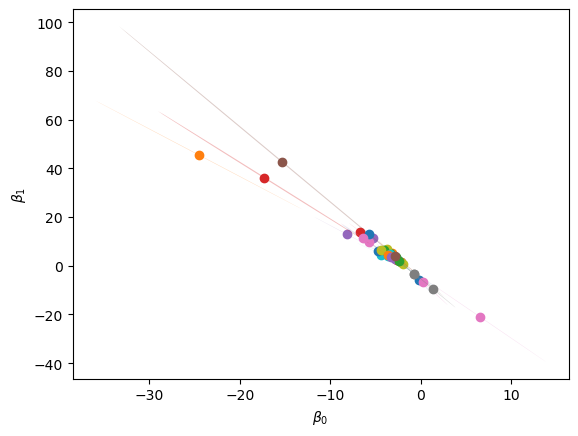

In [17]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend()

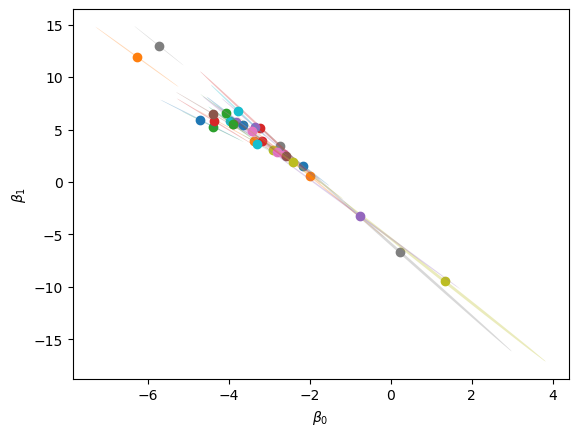

In [155]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    if not np.isin(r, regions_of_interest):
        continue
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend()

Text(0.5, 0, 'iteration (i)')

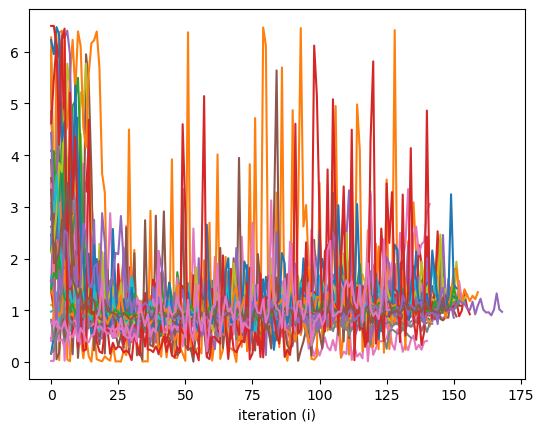

In [19]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(Rmle, label=r"$\hat{R}_{%s}$"%r)
plt.xlabel("iteration (i)")

# 3. EBCR

In [20]:
weights = np.zeros([len(regions)])
betas = np.zeros([len(regions), d])
Sigmas = np.zeros([len(regions), d, d])

In [21]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    betas[i] = bmle
    Sigmas[i] = np.linalg.pinv(Ihat_sdw)[2:,2:]
    weights[i] = 1/np.exp(np.linalg.slogdet(Sigmas[i])[1]/d)

In [22]:
mu = np.sum(weights[:,None] * betas, 0) / np.sum(weights)

In [23]:
eps = betas - mu

In [24]:
Phi = (np.sum(weights[:,None,None] 
              * (eps[:,:,None] * eps[:,None,:] - Sigmas), 0)
       / np.sum(weights)) 

In [25]:
W_eb = np.linalg.inv(np.eye(d) + Sigmas@np.linalg.inv(Phi))

In [26]:
th_eb = mu + (W_eb @ eps[:,:,None])[...,0]

In [27]:
Var_eb = W_eb @ Sigmas @ W_eb.transpose([0,2,1])

In [28]:
alpha = 0.05

In [29]:
chi_pa = np.sqrt(stats.chi2(d).ppf(1-alpha))

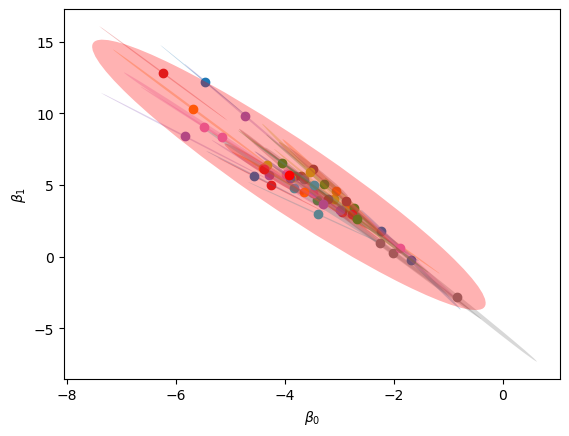

In [31]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_pa,
                       facecolor=p.get_facecolor(), alpha=0.3)
p = ax.scatter(mu[0], mu[1], color='red', label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(mu, Phi, ax, n_std = chi_pa,
                   facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$");# plt.legend(loc=(1.02,0))

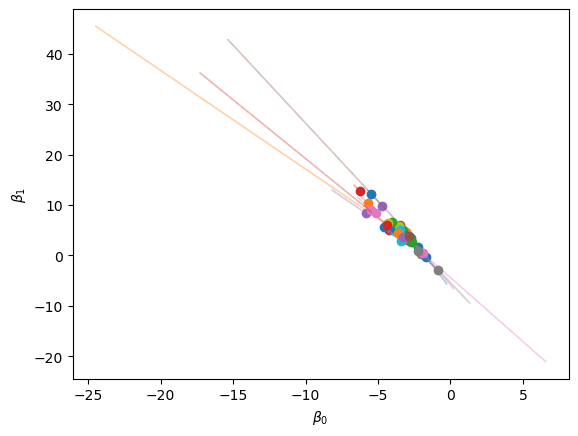

In [32]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    p = ax.scatter(*th_eb[i], label=r"$\hat{\beta}_{%s}$"%r)
    ax.arrow(*betas[i], *(th_eb[i]-betas[i]), width=0.01, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

In [33]:
def moments(A, eps, Sig, wgt):
    trAYYt = np.sum(A * eps[:,:,None] * eps[:,None,:], axis=(1,2))
    trAS = np.sum(A * Sig, axis=(1,2))
    
    ASA = A @ Sig @ A
    trASAYYt = np.sum(ASA * eps[:,:,None] * eps[:,None,:], axis=(1,2))
    trASAS = np.sum(ASA * Sig, axis=(1,2))
    
    m2 = max(0, np.sum(wgt * (trAYYt - trAS)) / np.sum(wgt))
    m4 = max(m2**2, np.sum(wgt * ((trAYYt - trAS)**2 + 2*trASAS - 4*trASAYYt)) / np.sum(wgt))
    
    return m2, m4

In [34]:
As = np.linalg.inv(Phi) @ Sigmas @ np.linalg.inv(Phi)

In [35]:
m2 = np.zeros([len(regions)])
m4 = np.zeros([len(regions)])

In [36]:
for i, _ in enumerate(regions):
    m2[i], m4[i] = moments(As[i], eps, Sigmas, weights)

In [37]:
import cv
importlib.reload(cv)

<module 'cv' from '/Users/blueconet/Documents/causepid/cv.py'>

In [38]:
CV_d = cv.CV(d, random_seed = 0)

In [39]:
chi_eb = [CV_d.cva(alpha, m2[i], m4[i])['cv']
          for i, _ in enumerate(regions)]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [40]:
chi_pa

2.447746830680816

In [114]:
np.array(chi_eb)

array([ 2.48145848,  3.09392542,  2.58019306,  2.55290345,  2.52531485,
        2.57734876, 18.77807296,  2.89074693,  2.45734458,  2.47577085,
        3.68125371, 20.20803311,  2.51239122,  2.47957761,  2.63534596,
        2.54628843,  2.46429697,  2.49016786,  4.734821  ,  5.13365997,
        2.47172092,  2.81174172,  2.61281538,  2.56001206,  2.58949139,
       10.05635419,  3.94237556,  2.97653353,  2.74299459,  1.94251593,
        2.52505309,  2.69376096,  2.48713279,  2.55682322,  1.84221045,
        2.48124429,  2.55282462,  3.08674758,  2.5255768 ,  2.53649392,
        2.50653039,  2.57219444,  2.61014248, 18.45277847,  2.45912925,
        2.68810408,  3.40234405])

In [113]:
np.array(chi_eb)[np.isin(regions,regions_of_interest)]

array([2.48145848, 2.58019306, 2.55290345, 2.52531485, 2.57734876,
       2.45734458, 2.47577085, 2.51239122, 2.47957761, 2.46429697,
       2.49016786, 4.734821  , 2.47172092, 2.81174172, 2.61281538,
       2.56001206, 2.58949139, 3.94237556, 2.97653353, 2.74299459,
       2.52505309, 2.69376096, 2.48713279, 2.48124429, 3.08674758,
       2.5255768 , 2.53649392, 2.50653039, 2.61014248, 2.45912925])

In [42]:
[CV_d.rho_l(chi_eb[i], m2[i], m4[i])['alpha']
 for i,_ in enumerate(regions)]

[0.04999752456222022,
 0.04999999956866926,
 0.05082818613237257,
 0.05046733949692039,
 0.04999999943775533,
 0.04990758694664332,
 0.05033236671516731,
 0.049999999642906946,
 0.04998878514200197,
 0.04999327295513663,
 0.04994802606200448,
 0.05489858131184205,
 0.049972565596576514,
 0.049991231881965435,
 0.049745553694408945,
 0.049913277096984864,
 0.04999428207477262,
 0.04999492122666919,
 0.04999997292764921,
 0.05267537487473143,
 0.04999732256513252,
 0.048480365010250354,
 0.04980739553210632,
 0.04999999645667689,
 0.049999998825434606,
 0.054862199713618436,
 0.049999981203757086,
 0.04862742987508502,
 0.048891865377095244,
 0.39150148781416194,
 0.050040118160865205,
 0.04899282763253267,
 0.04998690455225374,
 0.04981640604091399,
 0.3226949544743938,
 0.04999476913218248,
 0.04999999690229727,
 0.0499999794625674,
 0.049999999573099266,
 0.049708684780058326,
 0.04999012005867547,
 0.05041061949377045,
 0.04967555667418569,
 0.05225274787792466,
 0.04998044309768641,

In [43]:
[CV_d.rho(chi_pa, m2[i], m4[i])['alpha']
 for i,_ in enumerate(regions)]

[0.054156889250459264,
 0.11488793425997079,
 0.06455380403172895,
 0.06178486452900987,
 0.05915978536805469,
 0.06651074718890207,
 0.9916177692377413,
 0.10826502822937821,
 0.05116531780651544,
 0.05343104420916292,
 0.20128263471074953,
 0.9983243483969174,
 0.058037183170381895,
 0.05390990141973576,
 0.07457130389416772,
 0.06233070080657478,
 0.05201046232831228,
 0.055285397693887094,
 0.37277421273424916,
 0.022222425475591945,
 0.05291671115187721,
 0.0968138344436267,
 0.07138221947160156,
 0.06365902891480568,
 0.06635179274285982,
 0.9869895602124494,
 0.24426276935893887,
 0.12528849057290792,
 0.0877150890435838,
 -0.13675593661606295,
 0.058920627157567754,
 0.08052678676826215,
 0.054886613387463964,
 0.06358453913794118,
 0.04121868268332343,
 0.054126341991596535,
 0.062202307486677225,
 0.13180501007310594,
 0.05910492650425002,
 0.06087401555988422,
 0.057335176562627974,
 0.06378260149597892,
 0.07075747653763453,
 0.9918868662311552,
 0.05138368120388662,
 0.081

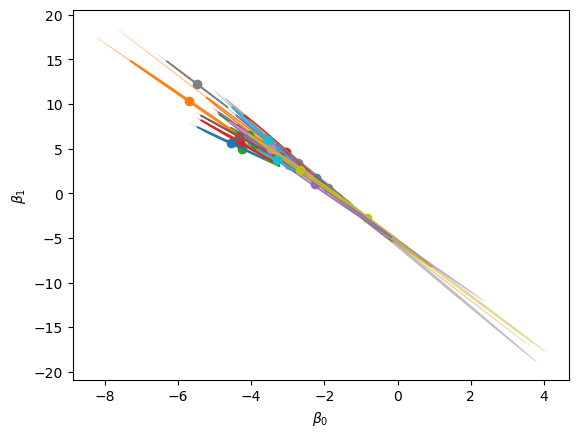

In [52]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    if not np.isin(r, regions_of_interest):
        continue
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                       edgecolor=p.get_facecolor(), alpha=1)
    confidence_ellipse(betas[i], Sigmas[i], ax, n_std = chi_pa,
                       facecolor=p.get_facecolor(), alpha=0.5)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

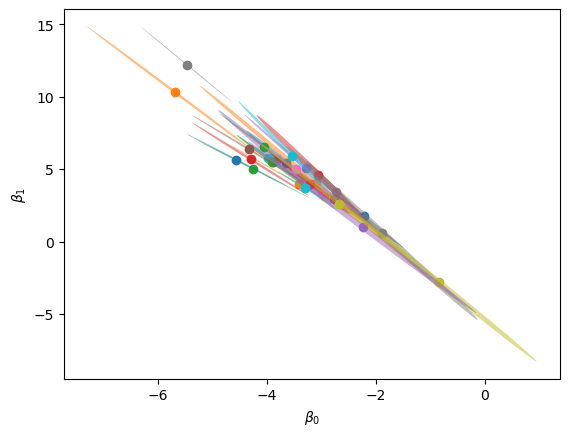

In [153]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    if not np.isin(r, regions_of_interest):
        continue
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                       facecolor=p.get_facecolor(), alpha=0.5)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend()

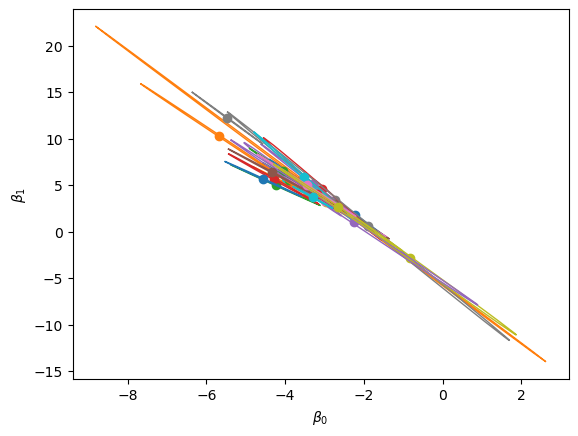

In [154]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    if not np.isin(r, regions_of_interest):
        continue
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
                       edgecolor=p.get_facecolor(), alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend()

## model fit

In [304]:
regions_of_interest

array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
       'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
       'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object)

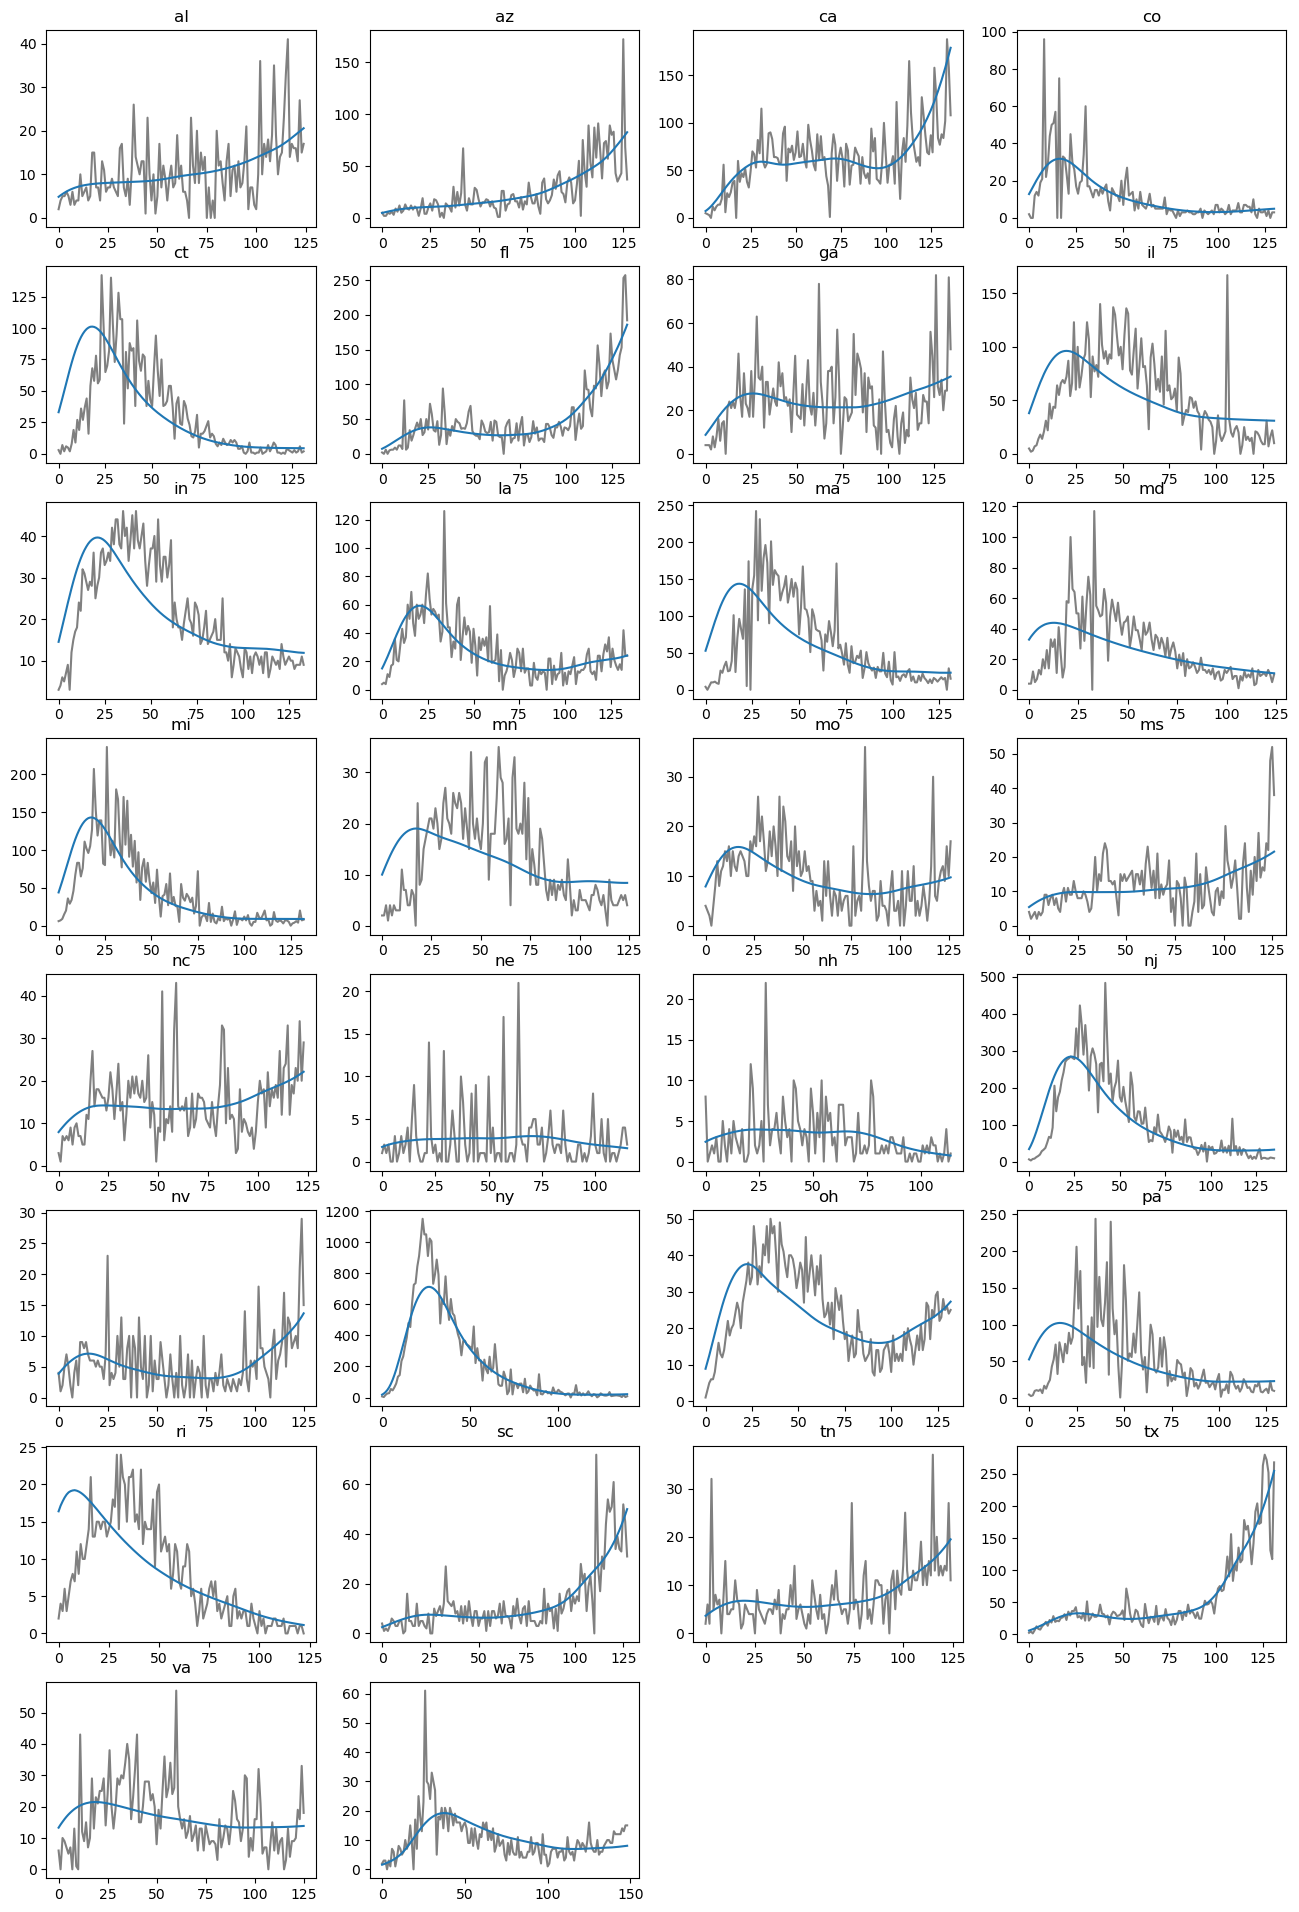

In [305]:
plt.figure(figsize=(16,int(len(regions_of_interest)/4+1)*3))
for i, r in enumerate(regions_of_interest):
    plt.subplot(int(len(regions_of_interest)/4+1),4,i+1)
    
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(Y, color='grey')
    plt.plot(EY)
    plt.title('%s'%r)

# 4. Causal Forecasting

In [55]:
def EY_t(beta, mu_0, A):
    assert A.shape[0] > T0
    
    T = A.shape[0]-T0
    R = np.zeros(T+T0)
    for t in np.arange(T+T0):
        o = np.exp(- beta @ A[t])
        p = 1 / (1 + o)
        R[t] = K * p 
        
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    return mu_0 * np.linalg.inv(np.eye(T+T0)-G)[:,0] @ Pi.T

In [56]:
T0 = 20
alpha = 1
K = 6.5

In [63]:
Tf = 30
Af = np.zeros([Tf, d])

In [98]:
regions

array(['al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'ia',
       'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn',
       'mo', 'ms', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh',
       'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'tn', 'tx', 'ut', 'va', 'vt',
       'wa', 'wi', 'wv'], dtype=object)

## CA

In [330]:
r = 'ca'
i = int(np.where(regions == r)[0])

In [331]:
regions[i]

'ca'

In [332]:
locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))

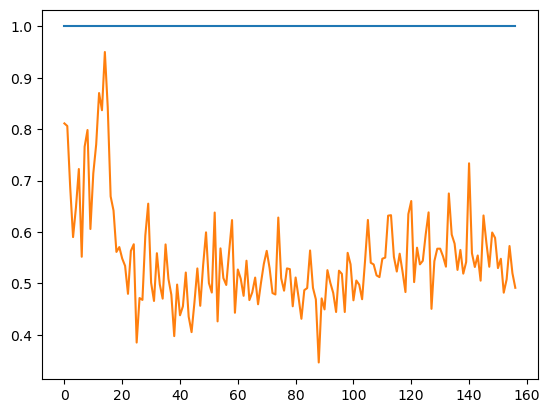

In [333]:
plt.plot(A)

In [231]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.3)

In [232]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [233]:
Te

167

In [234]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [235]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [237]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'eq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

In [243]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints=opt.NonlinearConstraint(
            cons, 0, chi_eb[i]**2, keep_feasible=True),
        method='trust-constr'
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints=opt.NonlinearConstraint(
            cons, 0, chi_eb[i]**2, keep_feasible=True),
        method='trust-constr'
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

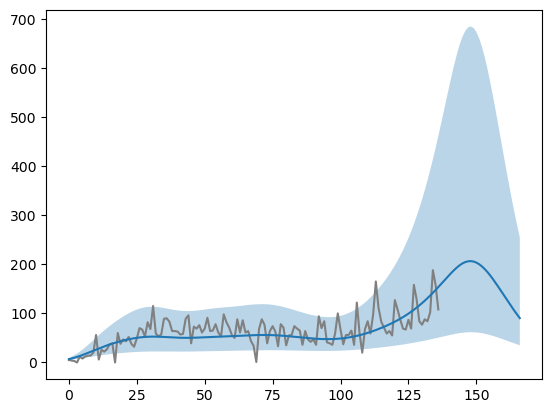

In [244]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

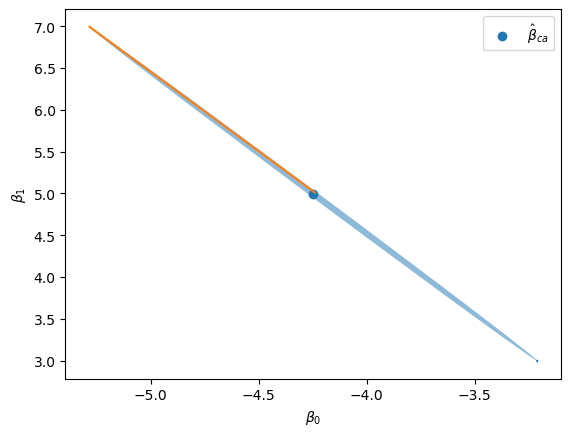

In [245]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

In [246]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [247]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [248]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [249]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [217]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    # print(t)
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

In [250]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints=opt.NonlinearConstraint(
            cons, 0, chi_eb[i]**2, keep_feasible=False),
        method='trust-constr'
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints=opt.NonlinearConstraint(
            cons, 0, chi_eb[i]**2, keep_feasible=False),
        method='trust-constr'
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

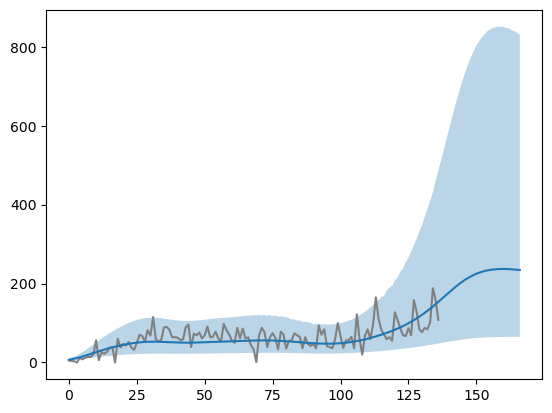

In [251]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

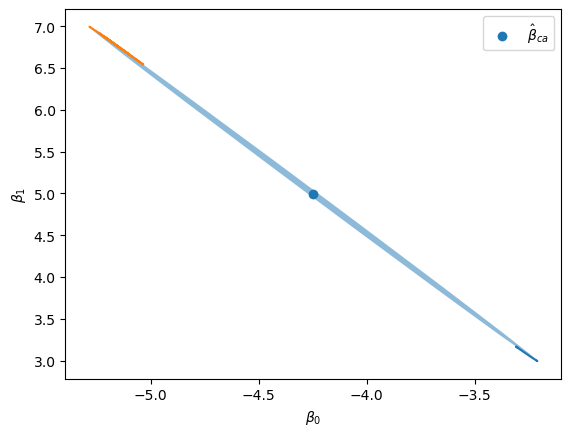

In [252]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

## TX

In [326]:
r = 'tx'
i = int(np.where(regions == r)[0])

In [327]:
regions[i]

'tx'

In [328]:
locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))

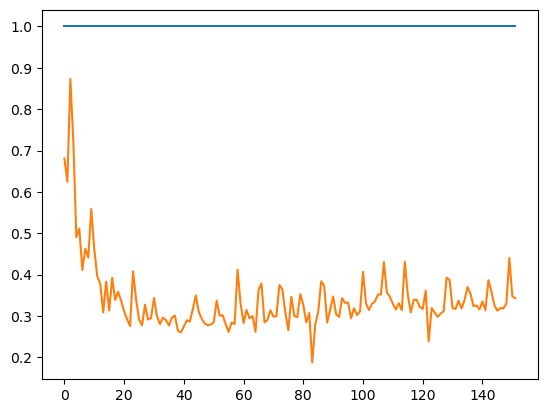

In [329]:
plt.plot(A)

In [258]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.3)

In [259]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [260]:
Te

162

In [261]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [262]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [263]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'eq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/162 [00:00<?, ?it/s]

In [243]:
# conf_band = np.zeros([Te, 2])
# beta_mm = np.zeros([Te,2,2])
# for t in trange(Te):
#     if t == 0:
#         init_min = th_eb[i]
#         init_max = th_eb[i]
#     else:
#         init_min = beta_mm[t-1,0]
#         init_max = beta_mm[t-1,1]
    
#     result_min = opt.minimize(
#         lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=True),
#         method='trust-constr'
#     )
#     result_max = opt.minimize(
#         lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=True),
#         method='trust-constr'
#     )
#     conf_band[t] = np.array([result_min.fun, -result_max.fun])
#     beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

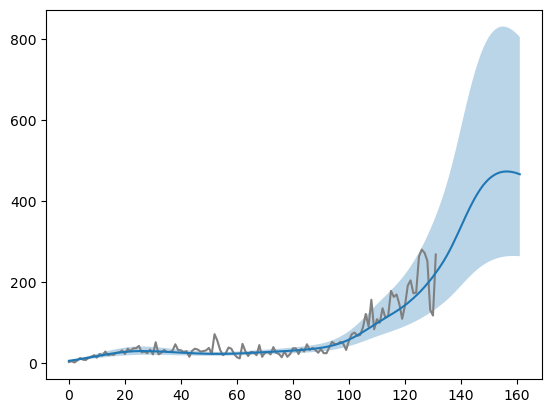

In [264]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

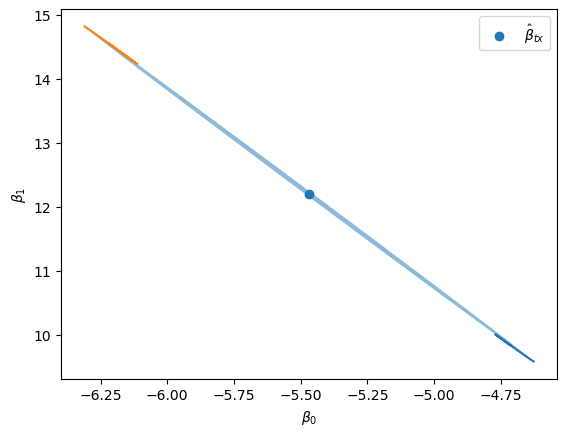

In [265]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

In [277]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.4)

In [278]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [279]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [280]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [281]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    # print(t)
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/162 [00:00<?, ?it/s]

In [274]:
# conf_band = np.zeros([Te, 2])
# beta_mm = np.zeros([Te,2,2])
# for t in trange(Te):
#     if t == 0:
#         init_min = th_eb[i]
#         init_max = th_eb[i]
#     else:
#         init_min = beta_mm[t-1,0]
#         init_max = beta_mm[t-1,1]
    
#     result_min = opt.minimize(
#         lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=False),
#         method='trust-constr'
#     )
#     result_max = opt.minimize(
#         lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=False),
#         method='trust-constr'
#     )
#     conf_band[t] = np.array([result_min.fun, -result_max.fun])
#     beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/162 [00:00<?, ?it/s]

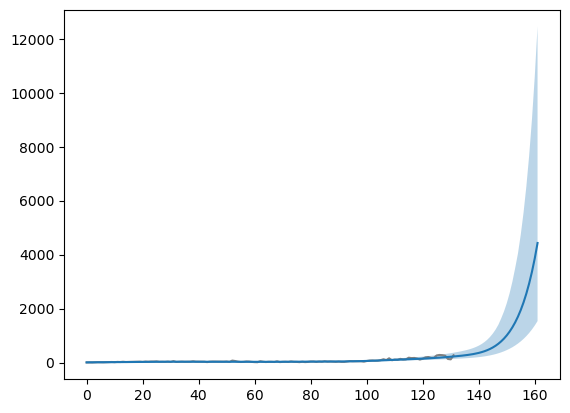

In [282]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

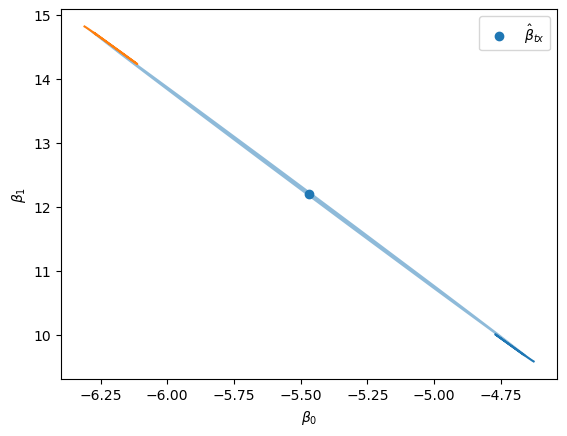

In [283]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

## NY

In [337]:
r = 'ny'
i = int(np.where(regions == r)[0])

In [338]:
chi_eb[i]

2.693760958723849

In [307]:
regions[i]

'ny'

In [308]:
locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))

In [289]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.3)

In [290]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [291]:
Te

170

In [292]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [293]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [294]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'eq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/170 [00:00<?, ?it/s]

In [243]:
# conf_band = np.zeros([Te, 2])
# beta_mm = np.zeros([Te,2,2])
# for t in trange(Te):
#     if t == 0:
#         init_min = th_eb[i]
#         init_max = th_eb[i]
#     else:
#         init_min = beta_mm[t-1,0]
#         init_max = beta_mm[t-1,1]
    
#     result_min = opt.minimize(
#         lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=True),
#         method='trust-constr'
#     )
#     result_max = opt.minimize(
#         lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=True),
#         method='trust-constr'
#     )
#     conf_band[t] = np.array([result_min.fun, -result_max.fun])
#     beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

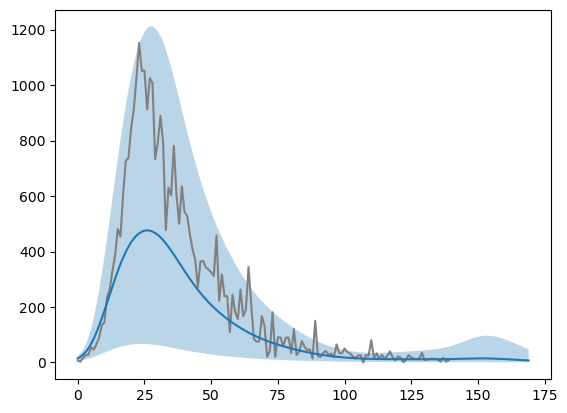

In [295]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

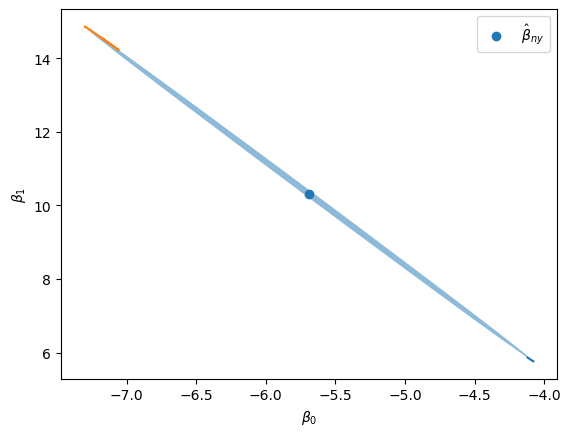

In [296]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

In [297]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [298]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [299]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [300]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [301]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])
for t in trange(Te):
    # print(t)
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
    
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/170 [00:00<?, ?it/s]

In [250]:
# conf_band = np.zeros([Te, 2])
# beta_mm = np.zeros([Te,2,2])
# for t in trange(Te):
#     if t == 0:
#         init_min = th_eb[i]
#         init_max = th_eb[i]
#     else:
#         init_min = beta_mm[t-1,0]
#         init_max = beta_mm[t-1,1]
    
#     result_min = opt.minimize(
#         lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=False),
#         method='trust-constr'
#     )
#     result_max = opt.minimize(
#         lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
#         bounds=np.transpose([lo, up]),
#         constraints=opt.NonlinearConstraint(
#             cons, 0, chi_eb[i]**2, keep_feasible=False),
#         method='trust-constr'
#     )
#     conf_band[t] = np.array([result_min.fun, -result_max.fun])
#     beta_mm[t] = np.array([result_min.x, result_max.x])

  0%|          | 0/167 [00:00<?, ?it/s]

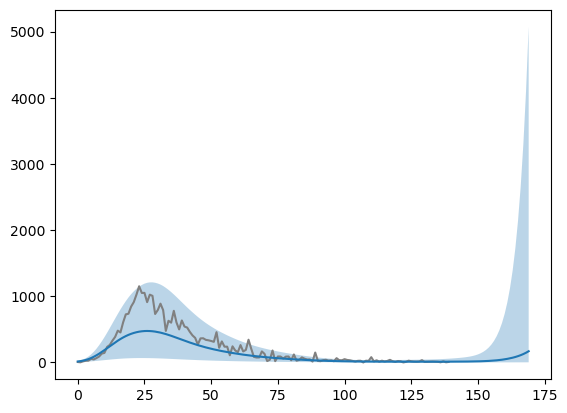

In [302]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

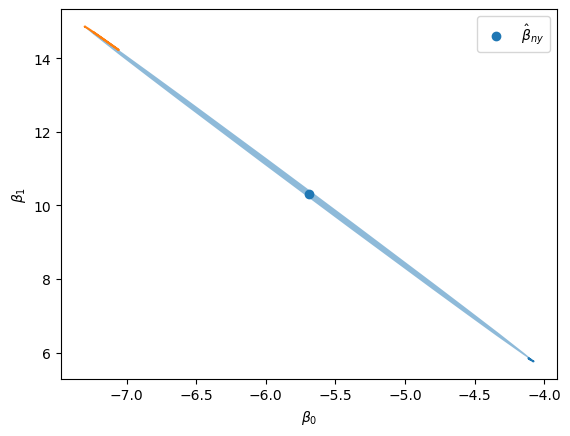

In [303]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

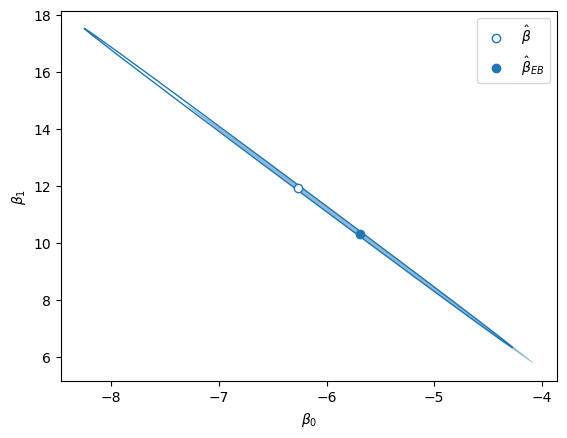

In [324]:
f, ax = plt.subplots(1,1)

confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor='C0', alpha=0.5)

confidence_ellipse(betas[i], Sigmas[i], ax, n_std = chi_pa,
                   edgecolor='C0', alpha=1)

ax.scatter(betas[i,0], betas[i,1], label=r"$\hat{\beta}$", alpha=1, color='C0', facecolors='white')

ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{EB}$", alpha=1, color='C0')

plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

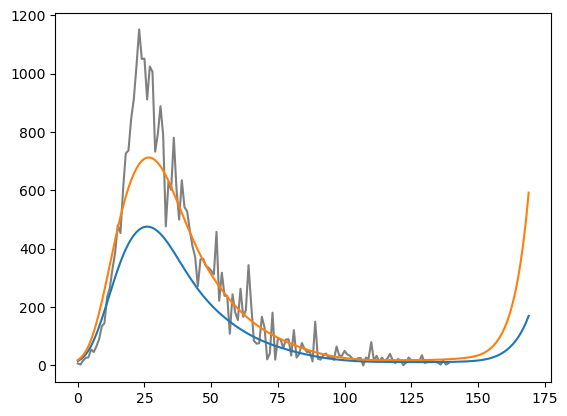

In [321]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.plot(EY_t(betas[i], mmle_0, Ae))

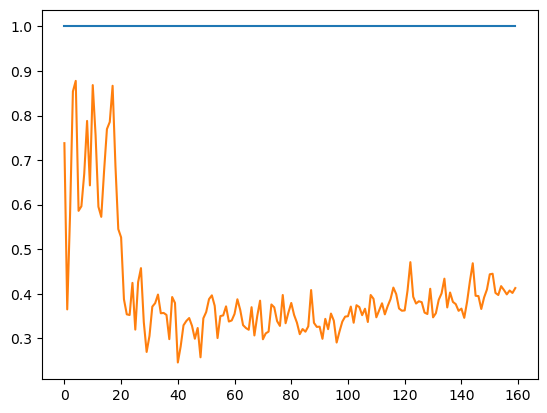

In [325]:
plt.plot(A)